In [327]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import math
import gc; gc.enable()


%matplotlib inline

In [328]:
data = pd.read_csv('./data/data.csv')

In [329]:
data=data.rename(columns = {"Unnamed: 0": "Date"})

In [330]:
data.tail()

,Date,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
146659,2017-04-24 19:00:00,16984.175000,1291.972222,1768.647222,654.152778,1058.680556,1062.383333,2238.380556,855.547222,289.441667,5559.388889,487.286111,1718.294444,NaN
146660,2017-04-24 20:00:00,17615.657540,1341.735714,1843.365873,683.256349,1108.247222,1122.049603,2388.324206,884.457540,311.366270,5647.025397,498.217460,1787.611905,NaN
146661,2017-04-24 21:00:00,17200.752778,1290.469444,1801.922222,675.925000,1091.652778,1086.563889,2318.411111,846.966667,290.966667,5521.511111,492.600000,1783.763889,NaN
146662,2017-04-24 22:00:00,16148.388889,1193.955556,1687.572222,641.322222,1011.200000,1007.902778,2140.886111,776.563889,258.008333,5256.850000,475.905556,1698.222222,NaN
146663,2017-04-24 23:00:00,14931.883333,1092.930556,1577.530556,583.055556,933.863889,920.994444,1937.283333,699.247222,231.258333,4895.633333,460.969444,1599.116667,NaN


In [331]:
data.Date = pd.to_datetime(data.Date)

In [332]:
data.set_index('Date', inplace = True)

In [333]:
data.sort_index(inplace=True)

In [334]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146664 entries, 2003-01-01 00:00:00 to 2019-08-31 23:00:00
Data columns (total 13 columns):
Load             146034 non-null float64
CAPITL           146034 non-null float64
CENTRL           146034 non-null float64
DUNWOD           146034 non-null float64
GENESE           146034 non-null float64
HUD VL           146034 non-null float64
LONGIL           127809 non-null float64
MHK VL           146034 non-null float64
MILLWD           146034 non-null float64
N.Y.C.           127809 non-null float64
NORTH            146034 non-null float64
WEST             146034 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 15.7 MB


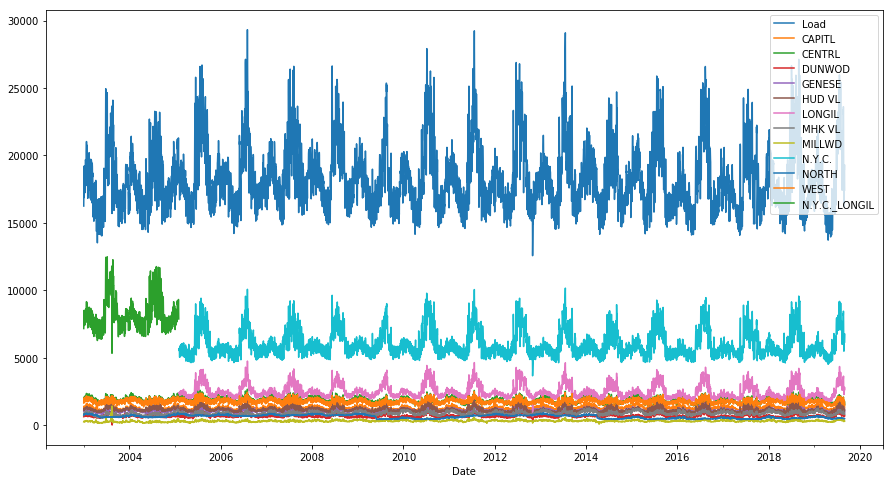

In [335]:
days = data.resample("D")
days_=days.mean()
days_.plot(kind = 'line', figsize=(15, 8))
plt.show()

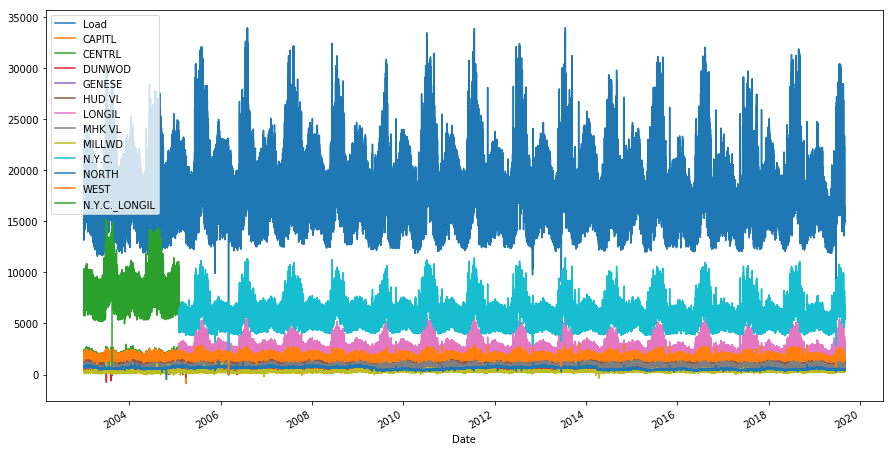

In [336]:
data.plot(kind = 'line', figsize=(15, 8))
plt.show()

In [337]:
data.tail()

,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
Date,,,,,,,,,,,,,
2019-08-31 19:00:00,18978.866667,1432.041667,1704.391667,755.041667,1045.016667,1219.691667,3035.408333,890.116667,343.716667,6431.391667,518.683333,1603.366667,NaN
2019-08-31 20:00:00,18835.633333,1444.800000,1701.433333,747.925000,1050.491667,1205.100000,2950.483333,894.091667,339.916667,6391.741667,491.141667,1618.508333,NaN
2019-08-31 21:00:00,18256.466667,1398.208333,1639.766667,728.100000,1008.441667,1142.266667,2787.541667,868.941667,330.808333,6281.708333,492.925000,1577.758333,NaN
2019-08-31 22:00:00,17426.316667,1318.433333,1554.750000,694.583333,952.525000,1066.483333,2598.775000,815.766667,311.116667,6107.491667,485.675000,1520.716667,NaN
2019-08-31 23:00:00,16364.112500,1225.181250,1441.912500,651.893750,888.337500,980.656250,2389.050000,746.581250,277.956250,5860.143750,488.106250,1414.293750,NaN


In [338]:
def get_slope(y):
    x = range(len(y))
    slope = np.polyfit(x, y, 1)[0]
    return slope

In [339]:
def get_acceleration(y):
    x = range(len(y))
    acc = 0.5*np.polyfit(x, y, 2)[0]
    return acc

In [340]:
def cyc_feats(data, feat):
    start = data.index[0].date().year-1
    data['cyc_{0}_x'.format(str(feat))] = np.cos(((2*np.pi)/data[feat])*(data['year']-(start))) #x-coord
    data['cyc_{0}_y'.format(str(feat))] = np.sin(((2*np.pi)/data[feat])*(data['year']-(start))) #y-coord
    return data

In [341]:
def create_features(data, tar):
    """
    Creates time series features from datetime index
    """
    data['date'] = data.index
    data['hour'] = data['date'].dt.hour
    data['dayofweek'] = data['date'].dt.dayofweek
    data['quarter'] = data['date'].dt.quarter
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    data['dayofyear'] = data['date'].dt.dayofyear
    data['dayofmonth'] = data['date'].dt.day
    data['weekofyear'] = data['date'].dt.weekofyear
    for i in [14, 28, 60, 90]:
        data['MA_{0}'.format(str(i))] = data[tar].rolling(24*i).mean() # rolling average
        data['MMAX_{0}'.format(str(i))] = data[tar].rolling(24*i).max() # rolling maximum
        data['MMIN_{0}'.format(str(i))] = data[tar].rolling(24*i).min() # rolling minimum
        data['MSTD_{0}'.format(str(i))] = data[tar].rolling(24*i).std() # rolling standard deviation
        data['MSLOPE_{0}'.format(str(i))] = data[tar].rolling(24*i).apply(lambda x: get_slope(x), raw=True) # rolling slope
        data['MACC_{0}'.format(str(i))] = data[tar].rolling(24*i).apply(lambda x: get_acceleration(x),raw=True) # rolling acceleration
    for i in [1, 7, 30, 60, 90, 180, 365]:
        # add the lagged Load as a feature
        data['lag_{0}'.format(str(i))] = data[tar].shift(24*i)
        # as well as the percentage of the current Load for each lagged closing price
        data['pct_{0}'.format(str(i))] = data['lag_{0}'.format(str(i))] / data[tar]
   
    #create cyclical features
    feats = ['month', 'dayofmonth', 'dayofyear', 'weekofyear']
    for feat in feats:
        data = cyc_feats(data, feat)
    return data

In [342]:
def split_data(data, split_date):
    return data[data.index < split_date].copy(), \
               data[data.index >=  split_date].copy()

In [343]:
def data_prep(data, isTest=0):
    used_cols = [col for col in data.columns.tolist() if col not in [target, _id]]
    keep_cols = used_cols
    if isTest:
        pass
    else:
        keep_cols += [target]
    used_cols = [col for col in keep_cols if col not in [target, _id]]
    return data[keep_cols].copy(), keep_cols, used_cols

In [344]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146664 entries, 2003-01-01 00:00:00 to 2019-08-31 23:00:00
Data columns (total 13 columns):
Load             146034 non-null float64
CAPITL           146034 non-null float64
CENTRL           146034 non-null float64
DUNWOD           146034 non-null float64
GENESE           146034 non-null float64
HUD VL           146034 non-null float64
LONGIL           127809 non-null float64
MHK VL           146034 non-null float64
MILLWD           146034 non-null float64
N.Y.C.           127809 non-null float64
NORTH            146034 non-null float64
WEST             146034 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 20.7 MB


In [345]:
data.isna().sum()

Load                630
CAPITL              630
CENTRL              630
DUNWOD              630
GENESE              630
HUD VL              630
LONGIL            18855
MHK VL              630
MILLWD              630
N.Y.C.            18855
NORTH               630
WEST                630
N.Y.C._LONGIL    128439
dtype: int64

In [346]:
#drop NaNs
target = 'Load'
data.dropna(subset = [target], inplace=True)
data.isna().sum()

Load                  0
CAPITL                0
CENTRL                0
DUNWOD                0
GENESE                0
HUD VL                0
LONGIL            18225
MHK VL                0
MILLWD                0
N.Y.C.            18225
NORTH                 0
WEST                  0
N.Y.C._LONGIL    127809
dtype: int64

In [347]:
data.shape

(146034, 13)

In [348]:
drop_cols = [col for col in data.columns.tolist() if col not in [target]]

In [349]:
data.drop(drop_cols, axis=1, inplace=True)

In [350]:
data.head()

,Load
Date,
2003-01-01 00:00:00,15415.625000
2003-01-01 01:00:00,14569.928571
2003-01-01 02:00:00,13812.200000
2003-01-01 03:00:00,13315.333333
2003-01-01 04:00:00,13156.333333


In [352]:
df_ = data['01-01-2017':'07-31-2019'].copy()

In [353]:
df_ = create_features(df_, target)

In [354]:
df_.dropna(inplace=True)

In [355]:
df_.head()

,Load,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,lag_365,pct_365,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,18942.233333,2018-01-01 01:00:00,1,0,1,1,2018,1,1,1,...,15763.208333,0.832173,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 02:00:00,18469.283333,2018-01-01 02:00:00,2,0,1,1,2018,1,1,1,...,15071.408333,0.816026,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 03:00:00,18163.875000,2018-01-01 03:00:00,3,0,1,1,2018,1,1,1,...,14485.033333,0.797464,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 04:00:00,18009.541667,2018-01-01 04:00:00,4,0,1,1,2018,1,1,1,...,14097.658333,0.782788,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 05:00:00,18158.241667,2018-01-01 05:00:00,5,0,1,1,2018,1,1,1,...,13937.300000,0.767547,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16


In [356]:
df_.tail()

,Load,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,lag_365,pct_365,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-31 19:00:00,24835.000000,2019-07-31 19:00:00,19,2,3,7,2019,212,31,31,...,24804.641667,0.998778,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 20:00:00,24219.675000,2019-07-31 20:00:00,20,2,3,7,2019,212,31,31,...,24019.750000,0.991745,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 21:00:00,23578.041667,2019-07-31 21:00:00,21,2,3,7,2019,212,31,31,...,23664.100000,1.003650,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 22:00:00,22177.316667,2019-07-31 22:00:00,22,2,3,7,2019,212,31,31,...,23159.708333,1.044297,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 23:00:00,20562.291667,2019-07-31 23:00:00,23,2,3,7,2019,212,31,31,...,21818.275000,1.061082,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268


In [357]:
train, test = split_data(df_, '06-01-2019')

In [360]:
y = train[target].shift(-(24*7)).dropna()

In [361]:
_id = 'date'
train, keep_cols, used_cols = data_prep(train)

In [366]:
X = train[used_cols].iloc[:-(24*7),:]

In [367]:
X.shape

(12213, 54)

In [368]:
y.shape

(12213,)

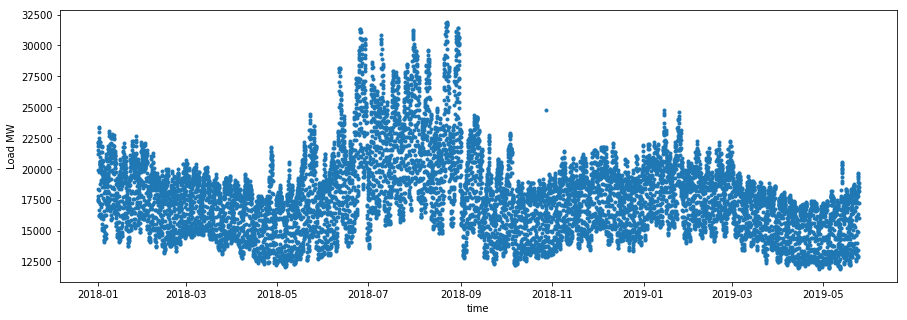

In [369]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('Load MW')
plt.plot(X.index,y, '.')
# plt.plot(X_test.index,y_test, '.')
plt.show()

In [370]:
reg = xgb.XGBRegressor()

In [371]:
reg.fit(X, y, 
        eval_set=[(X, y)],
        eval_metric = 'mae',
        early_stopping_rounds=25, 
        verbose=False) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [372]:
# evals_result = reg.evals_result()

In [373]:
# evals_result

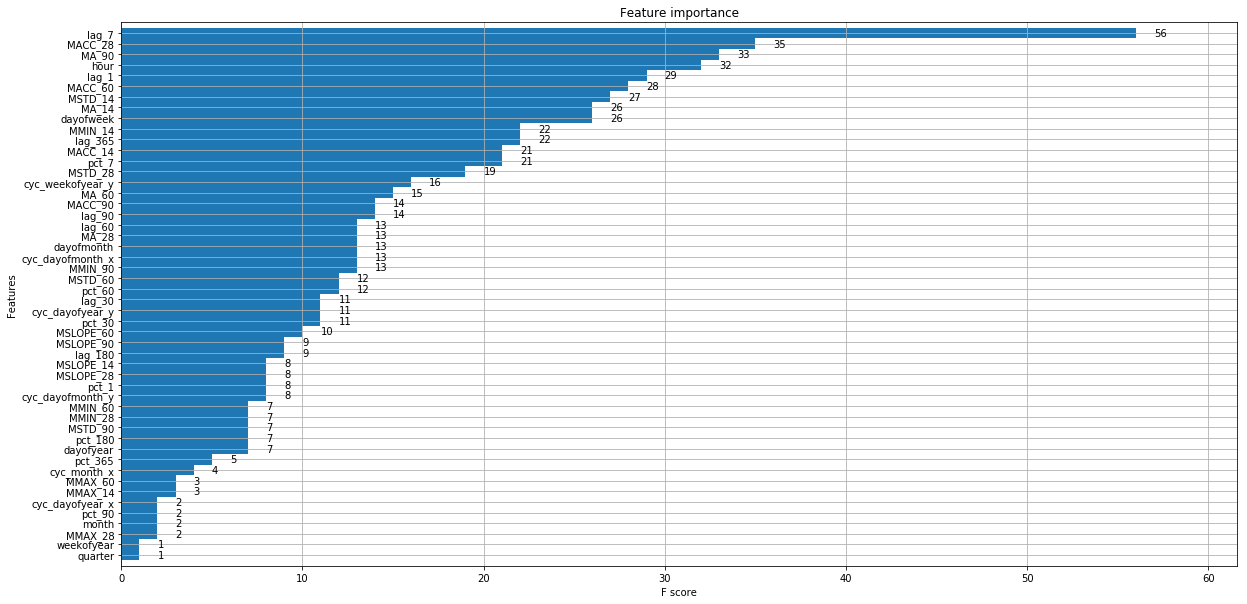

In [375]:
plt.rcParams["figure.figsize"] = (20, 10)
xgb.plot_importance(reg, height = 1)

In [376]:
# feats = reg.get_booster().get_score(importance_type="weight")
# feats

In [377]:
test, keep_cols, used_cols = data_prep(test)

In [378]:
y_pred = reg.predict(test[used_cols])


In [379]:
y_test = df['06-02-2019':'08-01-2019'][target].copy()

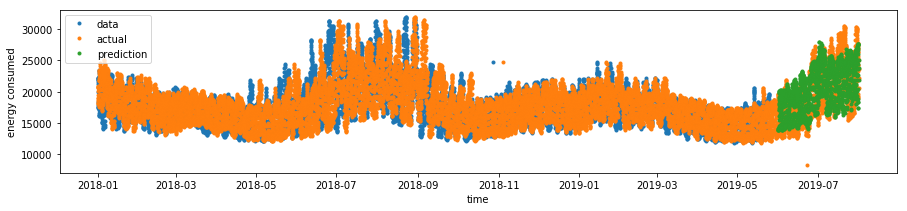

In [380]:
plt.figure(figsize=(15,3))
plt.xlabel('time')
plt.ylabel('energy consumed')
plt.plot(X.index, y, '.', label='data')
plt.plot(df_.index, df_[target], '.', label='actual')
plt.plot(test.index, y_pred, '.', label='prediction')
plt.legend()
# plt.xlim(left=date_from, right=date_to)
plt.show()

In [381]:
def plot_(data, target, begin, end, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(begin, end))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('energy consumed')
    plt.plot(data.index, target, '-', label='actual')
    plt.plot(test.index, y_pred, '-', label='prediction')
    plt.legend()
    plt.xlim(left=begin, right=end)

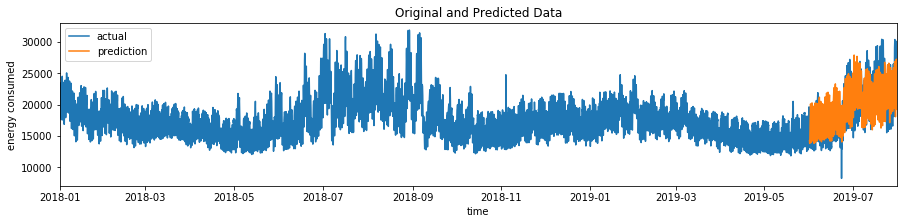

In [382]:
plot_(df_, df_[target], df_.index[0].date(), df_.index[-1].date(), 'Original and Predicted Data')

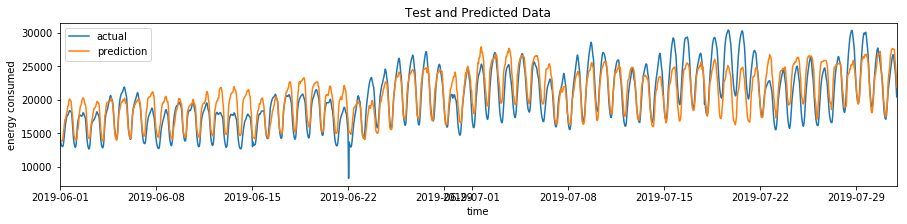

In [383]:
plot_(test, y_test, test[target].index[0], test[target].index[-1], 'Test and Predicted Data')

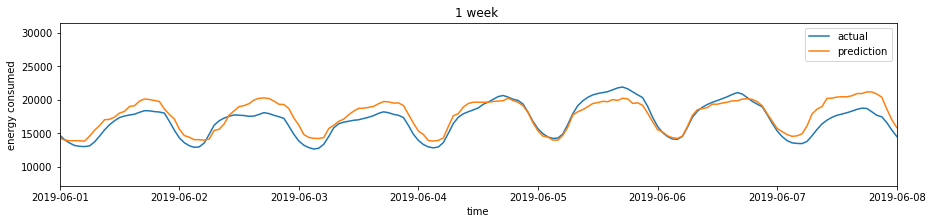

In [384]:
plot_(test, y_test, '06-01-2019', '06-08-2019', "1 week ")

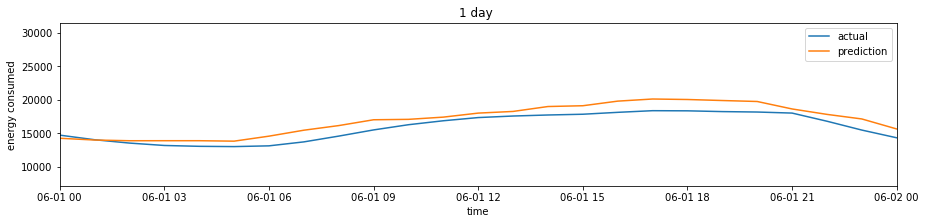

In [385]:
plot_(test, y_test, '06-01-2019', y_test.index[0], "1 day ")

In [386]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from numba import jit
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [387]:
def forecast_error(y_true, y_pred):
    return y_true - y_pred

In [388]:
def mean_forecast_error(forecast_error):
    return forecast_error.mean()

In [389]:
def smape(A, F):
    return (100/len(A)) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [390]:
MSE = mean_squared_error(y_test, y_pred)
print(MSE)

4373552.764383002


In [391]:
MAE = mean_absolute_error(y_test, y_pred)
print(MAE)

1694.2904259618067


In [392]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
print(MAPE)

8.45344048330275


In [393]:
sMAPE = smape(y_test, y_pred)
print(sMAPE)

8.265217718348605


In [397]:
sMAPE = smape(y_test[:(24)], y_pred[:(24)])
print(sMAPE)

6.590944276167627


In [395]:
RMSE = np.sqrt(MSE)
print(RMSE)

2091.304082237445


In [322]:
FE = forecast_error(y_test, y_pred)
MFE = mean_forecast_error(FE)
print(MFE)

886.7193281069722


In [323]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

0.796073294623913


,Load,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,lag_365,pct_365,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-01 00:00:00,19174.391667,2019-08-01 00:00:00,0,3,3,8,2019,213,1,31,...,NaN,NaN,0.707107,0.707107,1.0,-2.449294e-16,0.999565,0.029494,0.97953,0.201299
2019-08-01 01:00:00,18208.933333,2019-08-01 01:00:00,1,3,3,8,2019,213,1,31,...,NaN,NaN,0.707107,0.707107,1.0,-2.449294e-16,0.999565,0.029494,0.97953,0.201299
2019-08-01 02:00:00,17549.791667,2019-08-01 02:00:00,2,3,3,8,2019,213,1,31,...,NaN,NaN,0.707107,0.707107,1.0,-2.449294e-16,0.999565,0.029494,0.97953,0.201299
2019-08-01 03:00:00,17163.550000,2019-08-01 03:00:00,3,3,3,8,2019,213,1,31,...,NaN,NaN,0.707107,0.707107,1.0,-2.449294e-16,0.999565,0.029494,0.97953,0.201299
2019-08-01 04:00:00,17094.741667,2019-08-01 04:00:00,4,3,3,8,2019,213,1,31,...,NaN,NaN,0.707107,0.707107,1.0,-2.449294e-16,0.999565,0.029494,0.97953,0.201299


In [399]:
samp_ = data['01-01-2019':'07-31-2019'].copy()

In [404]:
from sklearn.model_selection import TimeSeriesSplit

In [405]:
tscv = TimeSeriesSplit(n_splits=5)

In [409]:
X.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MA_14,MMAX_14,...,lag_365,pct_365,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,1,0,1,1,2018,1,1,1,19015.850788,24233.433333,...,15763.208333,0.832173,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 02:00:00,2,0,1,1,2018,1,1,1,19025.425019,24233.433333,...,15071.408333,0.816026,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 03:00:00,3,0,1,1,2018,1,1,1,19034.414752,24233.433333,...,14485.033333,0.797464,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 04:00:00,4,0,1,1,2018,1,1,1,19042.206939,24233.433333,...,14097.658333,0.782788,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 05:00:00,5,0,1,1,2018,1,1,1,19047.876756,24233.433333,...,13937.300000,0.767547,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16


In [458]:
# for train_index, test_index in tscv.split(X[used_cols]):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

In [438]:
idx = df_.index[0]

In [439]:
idx

Timestamp('2018-01-01 01:00:00')

In [440]:
idx.replace(year = idx.year+1)

Timestamp('2019-01-01 01:00:00')

In [441]:
idx

Timestamp('2018-01-01 01:00:00')

In [457]:
# k = 3
# for i in range(k):
#     new_idx = idx.replace(year = idx.year+(i))
#     print(df_[str(new_idx)])

In [446]:
def temporal_split(X, n_splits):
    split_points = []
    n = len(X)
    for split in range(n_splits):
        split_points.append((n * split // n_splits, n * (split + 1) // n_splits))
    result = []
    for i in range(len(split_points)):
        result.append(split_points[i])
        for j in range(i + 1, len(split_points)):
            result.append((split_points[i][0], split_points[j][1]))
    return result

In [479]:
splits = temporal_split(df_, 3)
smape = []
for start, end in splits:
    sample = df_[start:end]
    split_at = int(len(sample) * 0.8)
    sample, keep_cols, used_cols = data_prep(sample)
    X_train = train[:split_at][used_cols].iloc[:-(24*7),:]
    y_train = train[:split_at][target].shift(-(24*7)).dropna()
    X_test = train[split_at:][used_cols]
    print('X_train shape: ',X_train.shape)
    print('y_train shape: ',y_train.shape)
    print('X_test shape:', X_test.shape)
    

X_train shape:  (3524, 54)
y_train shape:  (3524,)
X_test shape: (923, 54)
X_train shape:  (4447, 54)
y_train shape:  (4447,)
X_test shape: (0, 54)
X_train shape:  (4447, 54)
y_train shape:  (4447,)
X_test shape: (0, 54)
X_train shape:  (3524, 54)
y_train shape:  (3524,)
X_test shape: (923, 54)
X_train shape:  (4447, 54)
y_train shape:  (4447,)
X_test shape: (0, 54)
X_train shape:  (3524, 54)
y_train shape:  (3524,)
X_test shape: (923, 54)


In [472]:
X_test.shape

(3692, 56)

In [471]:
y_test.shape

(1464,)